In [1]:
import cv2
import numpy as np

# import image
image = cv2.imread('input.png')

# grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cv2.imshow('gray', gray)

# binary
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
#cv2.imshow('threshold', thresh)

# dilation
kernel = np.ones((10, 10), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
#cv2.imshow('dilated', img_dilation)

# find contours
# cv2.findCountours() function changed from OpenCV3 to OpenCV4: now it have only two parameters instead of 3
cv2MajorVersion = cv2.__version__.split(".")[0]
# check for contours on thresh
if int(cv2MajorVersion) >= 4:
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    im2, ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)

    # Getting ROI
    roi = image[y:y + h, x:x + w]

    # show ROI
    # cv2.imshow('segment no:'+str(i),roi)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), 2)

    if w > 15 and h > 15:
        cv2.imwrite('images//{}.png'.format(i), roi)

cv2.imshow('marked areas', image)
cv2.waitKey(0)

-1

In [12]:
# Load as greyscale

import cv2
import numpy as np
from commonfunctions import *
from scipy.stats import iqr
from scipy import stats
from collections import namedtuple
from dataclasses import dataclass






def getHorizontalProjectionProfile(image):
    horizontal_projection = np.sum(image, axis = 1) 
    return horizontal_projection 

def getVerticalProjectionProfile(image):
    vertical_projection = np.sum(image, axis = 0) 
    return vertical_projection 

def Visualize_Histogram(histogram,range_max):
    # # Create output image same height as text, 500 px wide
    m = np.max(histogram)
    w = 27
    result = np.zeros((histogram.shape[0],27))
    # # Draw a line for each row
    for row in range(range_max):
          cv2.line(result, (row,0), (int(histogram[row]*w/m),row), (255,255,255), 1)
    show_images([result.astype(np.uint8())],["result"])        

#vertical_projection = getVerticalProjectionProfile(thresh.copy()) 
#Visualize_Histogram(vertical_projection,vertical_projection.shape[0])

def FindGapSpaceLocation(Line):#ALG2
    VerticalProjection = getVerticalProjectionProfile(Line.copy())
    flag=0
    i=1
    G=[]
    L=[]
    while i < len(VerticalProjection):
        if VerticalProjection[i] == 0 and flag == 0:
            G.append(i)
            print(G)
            print(i)
            L.append( G[i] - G[i-1] )
            flag = 1
        elif VerticalProjection[i] != 0 and flag ==1:
            flag=0
        i+=1
    return G,L

def GapLengthFilteration(G,L):#ALG3
    iqrValue=iqr(L, rng=(25,75), interpolation='midpoint')
    i = 1
    while i < len(L):
        if L[i] != 0 and L[i] < iqrValue:
            del G[i]
            del L[i]
        i+=1
        
    meanValue = np.mean(L)
    i=1
    while i < len(L):
        if L[i] < meanValue:
            del G[i]
        i+=1
    return G,L


In [50]:
def FindBaselineIndex(line): #Alg. 4
    HP = []
    PV = []
    BaseLineIndex = 0
    thresh,thresh_img = cv2.threshold(line,127,255,cv2.THRESH_BINARY_INV)
    thresh_img = np.asarray(thresh_img)
    thresh_img = line

    HP = np.sum(thresh_img, axis = 1)
    PV_Indices = (HP > np.roll(HP,1)) & (HP > np.roll(HP,-1))
    for i in range(len(PV_Indices)):
        if PV_Indices[i] == True:
            PV.append(HP[i])
    #print(PV)
    MAX = max(PV)
    for i in range(len(HP)):
        if HP[i] == MAX:
            BaseLineIndex = i
#     print(BaseLineIndex)
#     cv2.line(thresh_img, (0, BaseLineIndex), (thresh_img.shape[1], BaseLineIndex), (255,255,255), 1)
#     cv2.imshow('binary',thresh_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return BaseLineIndex
    
    
def FindingMaxTrans(Line, BaseLineIndex): #Alg. 5
    MaxTrans = 0
    MaxTransIndex = BaseLineIndex
    i=BaseLineIndex
    while i > 0:
        CurrTrans = 0
        Flag = 0
        j=0
        while j < Line.shape[1]:
            if Line[i, j] == 1 and Flag == 0:
                CurrTrans += 1
                Flag = 1
            if Line[i, j] != 1 and Flag == 1:
                Flag = 0
            j += 1

        if CurrTrans >= MaxTrans:
            MaxTrans = CurrTrans
            MaxTransIndex = i
        i -= 1
    
#     cv2.line(Line, (0, MaxTransIndex), (Line.shape[1], MaxTransIndex), (50,100,150), 1)
#     cv2.imshow('binary',Line)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return MaxTransIndex

In [108]:

@dataclass
class SeparationRegions:
    StartIndex: int=0
    EndIndex: int=0
    CutIndex: int=0

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
    
    
    
#def CutPointIdentification(Line,Word,MTI): #Alg. 6
def CutPointIdentification(Word,MTI): #Alg. 6
    Flag=0
    #LineImage=cv2.imread(Line)
    VP=getVerticalProjectionProfile(Word)
    #MFV = stats.mode(VP)
    VPList = VP.tolist() #to be able to get the MFV
    Beginindex=0#ka2eni bashel el goz2 el black eli 3la el edges fl sora 3ashan ageb mode value mazbota
    EndIndex=len(VPList)
    for i in VPList:
        if i ==0:
            Beginindex+=1
        else:
            break
    for j in range(-1,-30,-1):
        if VPList[j]==0:
            EndIndex-=1
        else:
            break


    i=1
    VPListNew = VPList[Beginindex:EndIndex]
    MFV = max(set(VPListNew), key = VPListNew.count) 
    OutputSeparationRegions= []
    SRAppendFlag=False #initializa but do not append
    while i < Word.shape[1] :
        if SRAppendFlag == False:
            SR = SeparationRegions()
            SRAppendFlag = True
        if Word[MTI,i] == 1 and Word[MTI,i+1] == 0 and Flag == 0 : #CALCULATE END INDEX
            SR.EndIndex = i
            Flag = 1
        elif Word[MTI,i-1] == 0 and Word[MTI,i] == 1 and Flag == 1 : #CALCULATE START AND CUT INDEX
            SR.StartIndex = i
            MidIndex = ( SR.EndIndex + SR.StartIndex )/2
            MidIndex = int(MidIndex)
            IndexesEqualZero = np.where(VP == 0)
            IndexesEqualZero = np.asarray(IndexesEqualZero)
            IndexesEqualZero = IndexesEqualZero.tolist()
            IndexesEqualZero = IndexesEqualZero[0]
            IndexesEqualZero = np.array(IndexesEqualZero)
            #print(IndexesEqualZero)
            IndexesCorrect= IndexesEqualZero [ (IndexesEqualZero < SR.StartIndex) & (IndexesEqualZero > SR.EndIndex)] #condition shall be reversed like this
            #IndexesCorrect = IndexesEqualZero[ mask ]
            #print(IndexesEqualZero [ (IndexesEqualZero < SR.StartIndex) & (IndexesEqualZero > SR.EndIndex)])

            IndexesLessThanMFVAndEnd = np.where( (VP <= MFV) )#check end index
            IndexesLessThanMFVAndEnd = np.asarray(IndexesLessThanMFVAndEnd)
            IndexesLessThanMFVAndEnd=IndexesLessThanMFVAndEnd.tolist()
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd[0]
            IndexesLessThanMFVAndEnd = np.array(IndexesLessThanMFVAndEnd)
            IndexesLessThanMFVAndEnd = IndexesLessThanMFVAndEnd [ IndexesLessThanMFVAndEnd > SR.EndIndex ]
            #IndexesLessThanMFVAndEnd.append(2)

            IndexesLessThanMFVAndStartAndEnd = np.where( (VP <= MFV) )
            IndexesLessThanMFVAndStartAndEnd = np.asarray(IndexesLessThanMFVAndStartAndEnd)
            IndexesLessThanMFVAndStartAndEnd=IndexesLessThanMFVAndStartAndEnd.tolist()
            IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd[0]
            IndexesLessThanMFVAndStartAndEnd = np.array(IndexesLessThanMFVAndStartAndEnd)
            IndexesLessThanMFVAndStartAndEnd = IndexesLessThanMFVAndStartAndEnd [ (IndexesLessThanMFVAndStartAndEnd > SR.EndIndex) & (IndexesLessThanMFVAndStartAndEnd < SR.StartIndex) ]
            

            if len(IndexesCorrect) != 0: #neither connected nor overlapped characters
                SR.CutIndex = find_nearest(IndexesCorrect , MidIndex)

            elif VP[MidIndex] == MFV: #connected characters
                SR.CutIndex = MidIndex #line 19 on Alg.
            
            elif len(IndexesLessThanMFVAndEnd) != 0: 
                SR.CutIndex = find_nearest(IndexesLessThanMFVAndEnd[1:] , MidIndex)
            
            elif len(IndexesLessThanMFVAndStartAndEnd) != 0: #line 23
                SR.CutIndex = find_nearest(IndexesLessThanMFVAndStartAndEnd[1:] , MidIndex)
            else:
                SR.CutIndex = MidIndex
            
            if SRAppendFlag == True:
                OutputSeparationRegions.append(SR)
                SRAppendFlag = False
            Flag = 0
        i+=1
    return OutputSeparationRegions

print("finished running")

finished running


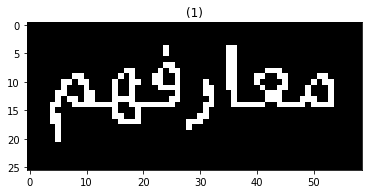

14
max
10


In [109]:
#TESTING ALG 4 AND 5
im = cv2.imread('images/15.png', cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY_INV)
#cv2.imshow('str',thresh/255)   
show_images([thresh[:,:]]) #di 255 not binary
BaselineIndex = FindBaselineIndex(thresh)
print(BaselineIndex)
MaxTransitionIndex = FindingMaxTrans(thresh/255, BaselineIndex)
print("max")
print(MaxTransitionIndex)

In [110]:
SeparationRegions = CutPointIdentification(thresh/255, MaxTransitionIndex)
print("Seeing Cut Point Identification")
for SR in SeparationRegions:
    print(SR.StartIndex)
    print(SR.EndIndex)
    print(SR.CutIndex)
    print("*********")

Seeing Cut Point Identification
9
7
8
*********
15
10
12
*********
22
19
21
*********
26
23
28
*********
35
31
33
*********
40
36
38
*********
50
45
47
*********


In [103]:


#vertical_projection = getVerticalProjectionProfile(im) 
  
#Visualize_Histogram(histogram(vertical_projection),vertical_projection.shape[0])

In [104]:
# import matplotlib.pyplot as plt

# im = cv2.imread('102.png', cv2.IMREAD_GRAYSCALE)

# im = 255-im

# img_row_sum = np.sum(im,axis=0).tolist()

# plt.plot(img_row_sum)
# plt.show()